<a id=contents></a>

# Exploratory Data Analysis
## Our clean data at a glance


[1. Explore POS and NE Tags](#insp)

[2. Target feature distribution](#corr)

[3. How does this affect it? (playing with some barplots and hue](#bar)

[4. EDA 1](#one)

[5. EDA 2](#two)

[6. EDA 3](#three)

[7. Conclusions and ideas going forward](#conc)

In [4]:

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from sklearn.linear_model import LogisticRegression
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import string

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

/Users/ipreoteasa/opt/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ipreoteasa/opt/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/ipreoteasa/opt/anaconda3/envs/learn-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
df = pd.read_csv('clean_data/clean_data.csv', ).drop(columns=['Unnamed: 0'])
df.head()

,Sentence #,Word,POS,Tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


<a id=insp ><a/> 

## 1. Explore POS and NE Tags
    
[LINK to table of contents](#contents)

In [6]:
pos_tag_breakdown = df.groupby(by=['POS', 'Tag']).count().sort_values(by='Word', ascending=False)
pos_tag_breakdown

,,Sentence #,Word
POS,Tag,,
NN,O,9171,9171
IN,O,7622,7622
DT,O,6275,6275
.,O,5190,5190
NNS,O,4681,4681
...,...,...,...
DT,I-art,1,1
RBR,B-tim,1,1
JJ,I-eve,1,1


In [7]:
pos_tag_breakdown.Word.quantile(.75)

154.25

In [8]:
# Since there are so many POS and NE categories, we'll only take the combinations that have a frequency above 
# the 75th quantile of 154
pos_tag_trim = pos_tag_breakdown.loc[pos_tag_breakdown.Word>154]
pos_tag_trim.head()

,,Sentence #,Word
POS,Tag,,
NN,O,9171,9171
IN,O,7622,7622
DT,O,6275,6275
.,O,5190,5190
NNS,O,4681,4681


In [9]:
pos_tag_trim = pos_tag_trim.reset_index()

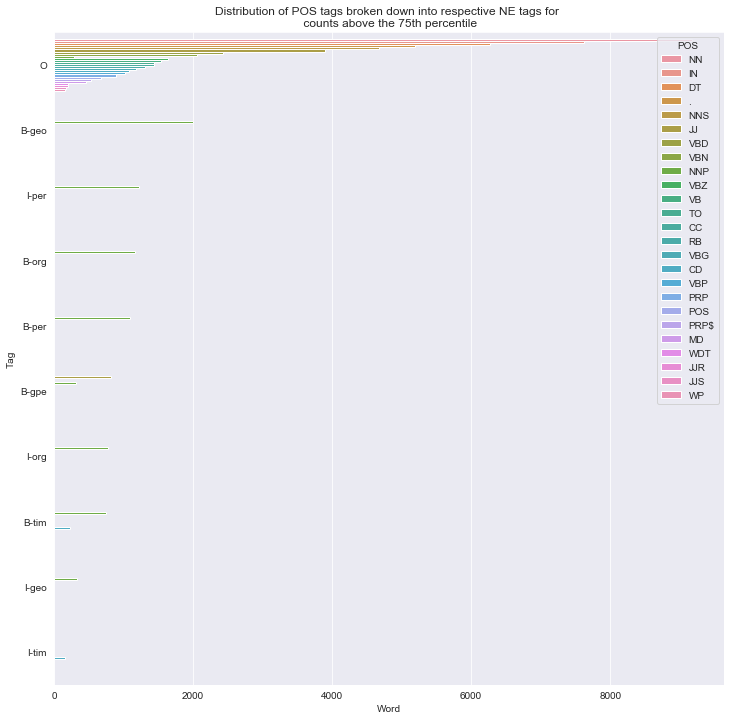

In [10]:
plt.figure(figsize=(12,12))
plt.title('Distribution of POS tags broken down into respective NE tags for \n counts above the 75th percentile')
sns.barplot(y = pos_tag_trim['Tag'], x= pos_tag_trim['Word'], hue = pos_tag_trim['POS']);

So we can see that, for the most numerically significant groups, the distribution is dominated by 'Other' (i.e. non-Named Entities). The largest group of named entities is the ~2000-odd geographical entities (B-geo). If you're struggling to understand the BIO formatting, know that the B signifies the beginning of an NE sequence (so 'B-geo' would be the *first* word of sequences like 'Europe' and 'South America') whereas I only relates to the words after the first one in an NE sequence (so 'Europe' would not be categorised as 'I-geo', but the second word of 'South America' would). The massive gap between the frequency of B-geo, NNP (2000) and I-geo, NNP (<300) tells us that generally speaking most proper noun geographical entities consist of a single token (like 'Europe', 'Asia', 'Nile').

Now let's visualise what this would look like without any of the non-entities. 

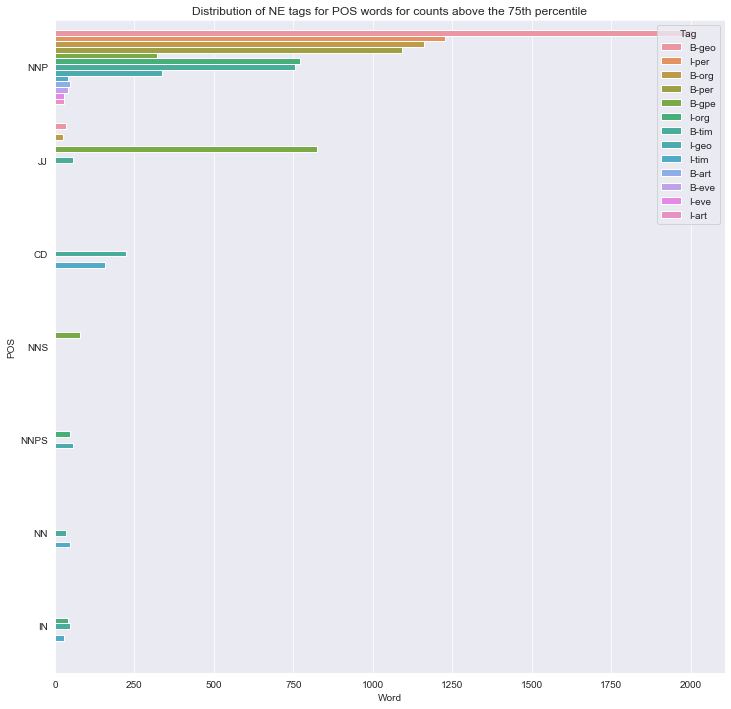

In [11]:
NE_breakdown = df.loc[df.Tag!='O'].groupby(by=['POS', 'Tag']).count().sort_values(by='Word', ascending=False)

NE_breakdown_trim = NE_breakdown.loc[NE_breakdown.Word>NE_breakdown.Word.quantile(.75)].reset_index()

plt.figure(figsize=(12,12))
plt.title('Distribution of NE tags for POS words for counts above the 75th percentile')
sns.barplot(y = NE_breakdown_trim['POS'], x= NE_breakdown_trim.Word, hue=NE_breakdown_trim['Tag'],);

Looking at our indexes, we can see that the vast majority of our NEs are indeed proper nouns (NNP), spanning multiple POS categories. 

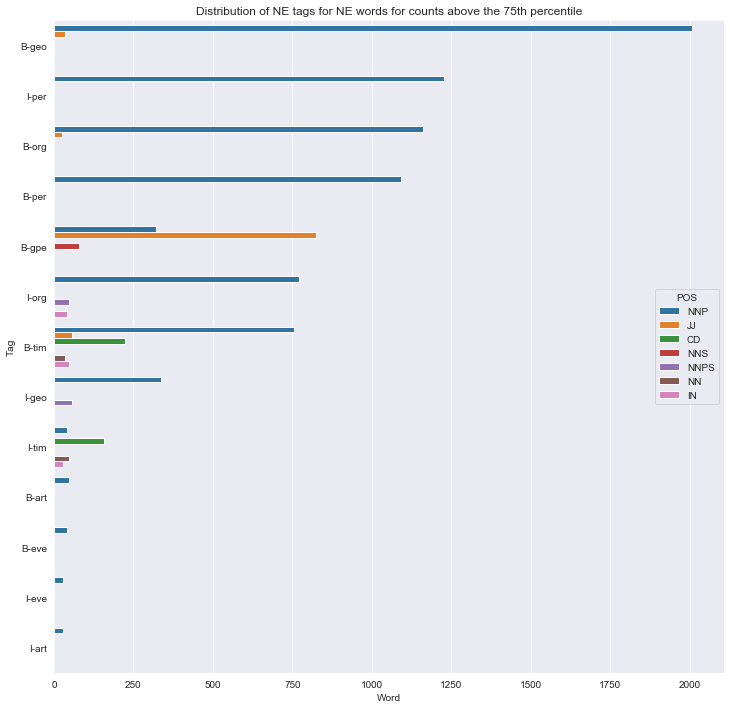

In [12]:
plt.figure(figsize=(12,12))
plt.title('Distribution of NE tags for NE words for counts above the 75th percentile')
sns.barplot(y = NE_breakdown_trim['Tag'], x= NE_breakdown_trim.Word, hue=NE_breakdown_trim['POS'],);

The same trends is reflected when plotting NE Tags broken down via POS. The only significant NE category to buck the trend is B-GPE. Let's inspect a few examples and see why. 

In [13]:
df.loc[(df.Tag=='B-gpe') & (df.POS=='JJ')].head(10)

,Sentence #,Word,POS,Tag
18,1.0,British,JJ,B-gpe
102,5.0,English,JJ,B-gpe
126,6.0,British,JJ,B-gpe
196,10.0,Iranian,JJ,B-gpe
276,13.0,European,JJ,B-gpe
293,13.0,Iranian,JJ,B-gpe
300,14.0,Nigerian,JJ,B-gpe
326,15.0,German,JJ,B-gpe
363,16.0,German,JJ,B-gpe
515,22.0,Somali,JJ,B-gpe


As you'd expect this comes from the wide variety of adjectives (JJ) that identify a particular geo-political entity, e.g. "the German Army", "the Iranian Embassy". 

<a id=corr ><a/> 

## 2.  Target feature distribution
    
[LINK to table of contents](#contents)

As we can see, almost 90% of the NE tags are 'O' - not Named Entities. 

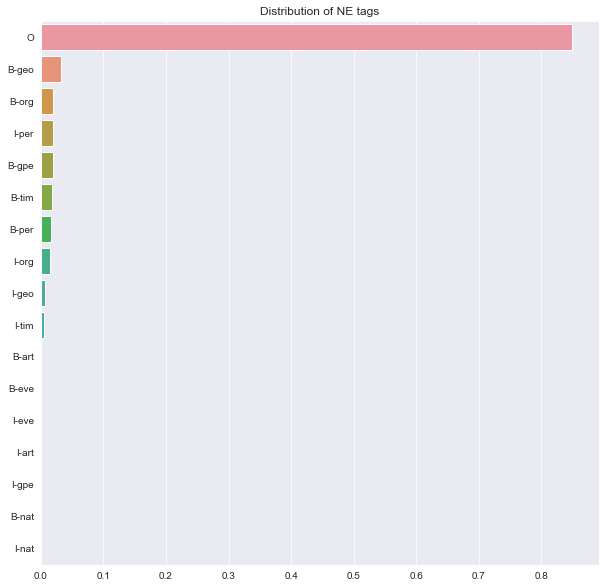

In [14]:
plt.figure(figsize=(10,10))
plt.title('Distribution of NE tags')
sns.barplot(x = df.Tag.value_counts(True).values, y= df.Tag.value_counts(True).index,);

Removing the 'O's, we see that geographical entities (e.g. the Nile) dominate, followed by organisations (UNICEF), geo-political (NATO) and personal entities (Tony Blair). We're dealing with a severe class imbalance, for which the only reasonable solution will be to provide our models with class weights. 

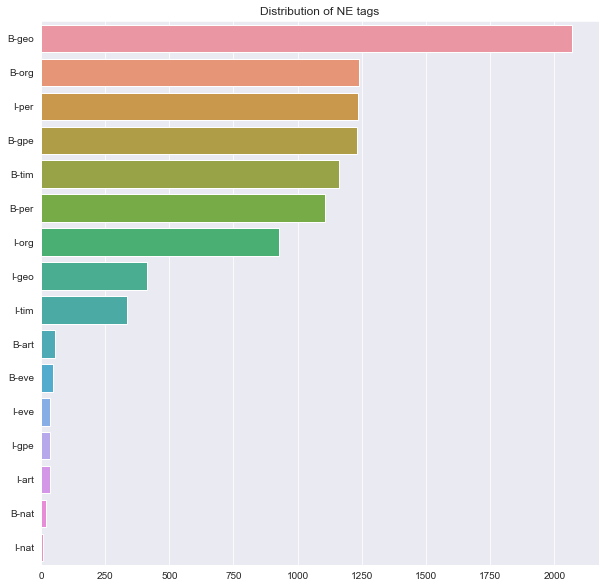

In [15]:
plt.figure(figsize=(10,10))
plt.title('Distribution of NE tags')
sns.barplot(x = df.loc[df.Tag!='O'].Tag.value_counts().values, y= df.loc[df.Tag!='O'].Tag.value_counts().index,);

<a id=bar ><a/> 

## 3. Measuring the correlation between variables
   
[LINK to table of contents](#contents)

For our categorical variables (POS and NE tags), we'll be plotting a confusion matrix of the Uncertainty Coefficient (or Theil's U), which can be thought of as *normalised mutual information*. I'll go into the maths in more detail further down with an example. 

I'll be using the dython package very kindle provided [here](https://github.com/shakedzy/dython). 

In [21]:
from collections import Counter
import scipy.stats as ss

In [27]:
from dython.nominal import conditional_entropy, associations

def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

Now we don't necessarily want to look at all of the categories in POS and Tag, since that would be useless for the most part. Previously we identified what the most frequent POS tags were for NE words and we can take the top ones here. 

In [41]:
NE_breakdown_trim.POS.value_counts(ascending=False).index

Index(['NNP', 'JJ', 'IN', 'NNPS', 'NN', 'CD', 'NNS'], dtype='object')

In [48]:
corr_df = df.loc[df.Tag.isin(['B-gpe', 'B-org', 'I-per', 'B-per', 'I-org', 'B-tim', 'I-gpe', 'I-tim'])]
corr_df = corr_df.loc[corr_df.POS.isin(['NNP', 'JJ', 'IN', 'NNPS', 'NN', 'CD', 'NNS'])]

corr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7132 entries, 18 to 66158
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sentence #  7132 non-null   float64
 1   Word        7132 non-null   object 
 2   POS         7132 non-null   object 
 3   Tag         7132 non-null   object 
dtypes: float64(1), object(3)
memory usage: 278.6+ KB


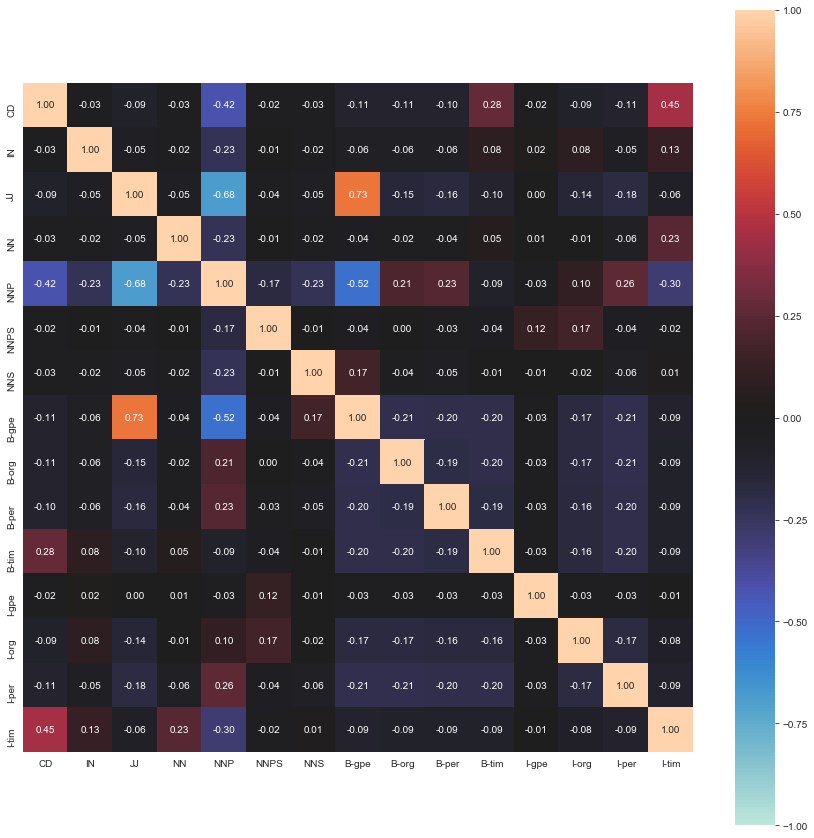

In [50]:
associations(pd.concat([pd.get_dummies(corr_df.POS), pd.get_dummies(corr_df.Tag)], axis=1), theil_u=True, figsize=(15,15));

Now what we see above very neatly visualises and confirms some of our prior insights:
* the strongest positive relationship is between adjectives (JJ) and geo-political entities (B-gpe)
* 

<a id=one ><a/> 

## 4. EDA 1
    
[LINK to table of contents](#contents)

<a id=two ><a/> 

## 5. EDA 2
    
[LINK to table of contents](#contents)

<a id=three ><a/> 

## 6. EDA 3
    
[LINK to table of contents](#contents)

<a id=conc ><a/> 

## 7. Conclusions and ideas going forward
    
[LINK to table of contents](#contents)